使用許諾条件

①	設計一次エネルギー消費量算定法に基づく計算方法をPythonによりコーディングし、Jupyter notebook形式で保存したファイル（以下、本ファイルと呼ぶ）の著作権は、一般社団法人日本サステナブル建築協会に帰属します。
Copyright©2019. 一般社団法人日本サステナブル建築協会
All rights reserved. 

②	本ファイルは、住戸の設計一次エネルギー消費量算定方法に係る「平成28年省エネルギー基準に準拠したエネルギー消費性能の評価に関する技術情報（住宅）2.1算定方法（第九章第一節 太陽光発電設備）」に示す計算方法に基づき、国土交通省国土技術政策総合研究所・国立研究開発法人建築研究所、株式会社ユーワークス、株式会社住環境計画研究所が作成したものです。

③	本ファイルは、計算方法に示す計算過程の確認及び調査研究等に活用することを目的として作成されたものであり、一般社団法人日本サステナブル建築協会は著作権について放棄はしませんが、使用する各人の自己責任において仕様を変更することを妨げるものではありません。ただし、本ファイルによる計算結果を住宅の省エネルギー基準で規定する設計一次エネルギー消費量の結果として公的な申請に用いることはできません。

④	本ファイルを変更するかしないかを問わず、以下の条件を満たす場合に限り、頒布および使用が許可されます。
1.	頒布物の付属ドキュメント等の資料に、上記の著作権表示、本条件一覧、および下記免責条項を含めること。
2.	書面による特別の許可なしに、本ファイルから派生した製品の宣伝または販売の促進に、一般社団法人日本サステナブル建築協会、国土技術政策総合研究所・国立研究開発法人建築研究所および株式会社ユーワークス、株式会社住環境計画研究所の名前またはコントリビューターの名前を使用してはならない。

⑤	本ファイルは、著作権者およびコントリビューターによって「現状のまま」提供されており、明示黙示を問わず、商業的な使用可能性、および特定の目的に対する適合性に関する暗黙の保証も含め、またそれに限定されない、いかなる保証もありません。著作権もコントリビューターも、事由のいかんを問わず、損害発生の原因いかんを問わず、かつ責任の根拠が契約であるか厳格責任であるか（過失その他の）不法行為であるかを問わず、仮にそのような損害が発生する可能性を知らされていたとしても、本ファイルの使用によって発生した（代用品または代用サービスの調達、使用の喪失、データの喪失、利益の喪失、業務の中断も含め、またそれに限定されない）直接損害、間接損害、偶発的な損害、特別損害、懲罰的損害、または結果損害について、一切の責任を負わないものとします。



In [1]:
import nbimporter
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from s11_02_solar_radiation import \
    load_solrad, \
    get_Theta_ex, \
    calc_I_s_d_t

Importing Jupyter notebook from s11_02_solar_radiation.ipynb


# 第九章　自然エネルギー利用設備 / Chapter 9 PV System

## 第一節　太陽光発電設備 / Section 1  Solar power plant

1．適用範囲～4．記号及び単位は省略

1. Scope of application ~ 4. Symbols and units are omitted

### 5．太陽光発電設備による発電量 / Amount of power generated by photovoltaic power generation

$$\large
E_{PV,d,t} = \sum_{i}^{n} E_{p,i,d,t}
$$

$E_{PV,d,t}$：日付$d$の時刻$t$における1時間当たりの太陽光発電設備による発電量(kWh/h) / The amount of power generated by the photovoltaic power generation facility per hour at time $ t $ of date $ d $  
$E_{p,i,d,t}$：日付$d$の時刻$t$における1時間当たりの太陽電池アレイ$i$の発電量(kWh/h) / PV array $ i $ generated energy per hour at time $ t $ on date $ d $  
$n$：太陽電池アレイの数(最大4) / Number of PV arrays (up to 4)  

In [2]:
def calc_E_E_PV_d_t(pv_list, df):
    """太陽光発電設備の発電量 (1)

    :param pv_list: 太陽光発電設備のリスト
    :type pv_list: list
    :param df: load_solrad の返り値
    :type df: DateFrame
    :return: 日付dの時tにおける 1 時間当たりの太陽光発電設備による発電量（kWh/h）
    :rtype: ndarray
    """

    if pv_list is not None:
        return np.sum([calc_E_p_i_d_t(**pv, df=df) for pv in pv_list], axis = 0)
    else:
        return np.zeros(24 * 365)


### 6．太陽電池アレイによる発電量 / Amount of power generation by PV array

$$\large
E_{p,i,d,t} = P_{p,i} \times \frac{1}{\alpha_p} \times I_{S,i,d,t} \times K_{p,i,d,t} \times 10^{-3}
$$

$P_{p,i}$：太陽電池アレイ$i$のシステム容量(kW) / System capacity of PV array $ i $  
$\alpha_p$：基準状態の日射強度(kW/m<sup>2</sup>) / Solar radiation intensity of reference state  
$I_{S,i,d,t}$：日付$d$の時刻$t$における太陽電池アレイ$i$の設置面の単位面積当たりの日射量(W/m<sup>2</sup>) / Solar radiation amount per unit area of installation surface of PV array $ i $ at time $ t $ of date $ d $  
$K_{p,i,d,t}$：日付$d$の時刻$t$における太陽電池アレイ$i$の総合設計係数 / Overall design factor of PV array $ i $ at time $ t $ of date $ d $

In [3]:
def calc_E_p_i_d_t(P_p_i, P_alpha, P_beta, df, pv_type, pv_setup, etr_IN_r):
    """太陽電池アレイの発電量 (2)

    :param P_p_i: 太陽電池アレイiのシステム容量（kW）
    :type P_p_i: float
    :param P_alpha: 方位角 (°)
    :type P_alpha: float
    :param P_beta: 傾斜角 (°)
    :type P_beta: float
    :param df: load_solrad の返り値
    :type df: DateFrame
    :param pv_type: 太陽電池アレイの種類
    :type pv_type: str
    :param pv_setup: 太陽電池アレイ設置方式
    :type pv_setup: str
    :param etr_IN_r: パワーコンディショナの定格負荷効率
    :type etr_IN_r: float
    :return: 日付dの時刻tにおける 1 時間当たりの太陽電池アレイiの発電量
    :rtype: ndarray
    """

    # 基準状態の日射強度
    alpha_p = get_alpha_p()

    # 設置面の単位面積当たりの日射量
    I_s_i_d_t = calc_I_s_d_t(P_alpha, P_beta, df)

    # 外気温度
    Theta_A_d_t = get_Theta_A_d_t(df)

    # 総合設計係数
    K_p_i_d_t = calc_K_p_i_d_t(pv_type, pv_setup, etr_IN_r, Theta_A_d_t, I_s_i_d_t)

    return P_p_i * (1/alpha_p) * I_s_i_d_t * K_p_i_d_t * 10**(-3)


### 7．太陽電池アレイのシステム容量 / System capacity of PV array

省略

ommision

### 8．基準状態の日射強度 / Solar radiation intensity of reference state

基準状態の日射強度$\alpha_p$として1.0kW/m<sup>2</sup> を用いる。

Use 1.0 kW / m<sup>2</sup> as the solar radiation intensity $\alpha_p$ of the standard state.

In [4]:
def get_alpha_p():
    """基準状態の日射強度

    :return: 基準状態の日射強度
    :rtype: float
    """
    return 1.0


### 9．太陽電池アレイの総合設計係数 / Integrated design factor of PV array

$$\large
K_{p,i,d,t} = K_{HS,i} \times K_{PD,i} \times K_{PT,i,d,t} \times K_{PA,i} \times K_{PM,i} \times K_{IN}
$$

$K_{HS,i}$：太陽電池アレイ$i$の日陰補正係数(表の値) / Shade correction factor of PV array $ i $ (values in the table)  
$K_{PD,i}$：太陽電池アレイ$i$の経時変化補正係数(表の値) / Aging correction factor of PV array $ i $ (value in the table)  
$K_{PT,i,d,t}$：日付$d$の時刻$t$における太陽電池アレイ$i$の温度補正係数 / Temperature correction factor of PV array $ i $ at time $ t $ of date $ d $  
$K_{PA,i}$：太陽電池アレイ$i$のアレイ負荷整合補正係数(表の値) / Array load matching correction factor for PV array $ i $ (value in the table)  
$K_{PM,i}$：太陽電池アレイ$i$のアレイ回路補正係数(表の値) / Array circuit correction factor of PV array $ i $ (value in the table)  
$K_{IN}$：インバータ回路補正係数(表の値) / Inverter circuit correction factor (value in the table)

In [5]:
def calc_K_p_i_d_t(pv_type, pv_setup, etr_IN_R, Theta_A_d_t, I_s_i_d_t):
    """太陽電池アレイの総合設計係数 (3)

    :param pv_type: 太陽電池アレイの種類
    :type pv_type: str
    :param pv_setup: 太陽電池アレイ設置方式
    :type pv_setup: str
    :param etr_IN_R: パワーコンディショナの定格負荷効率
    :type etr_IN_R: float
    :param Theta_A_d_t: 日付dの時刻tにおける外気温度（℃）
    :type Theta_A_d_t: ndarray
    :param I_s_i_d_t: 日付dの時刻tにおける太陽電池アレイiの設置面の単位面積当たりの日射量（W/m2）
    :type I_s_i_d_t: ndarray
    :return: 太陽電池アレイの総合設計係数
    :rtype: ndarray
    """

    # 日陰補正係数, 啓示変化補正係数, アレイ負荷整合補正係数, アレイ回路補正係数
    if pv_type == '結晶シリコン系':
        K_HS_i = get_table_4()[0][0]
        K_PD_i = get_table_4()[1][0]
        K_PA_i = get_table_4()[2][0]
        K_PM_i = get_table_4()[3][0]
    elif pv_type == '結晶シリコン系以外':
        K_HS_i = get_table_4()[0][1]
        K_PD_i = get_table_4()[1][1]
        K_PA_i = get_table_4()[2][1]
        K_PM_i = get_table_4()[3][1]
    else:
        raise NotImplementedError()

    # 太陽電池アレイの温度補正係数
    K_PT_i_d_t = calc_K_PT_i_d_t(pv_type, pv_setup, Theta_A_d_t, I_s_i_d_t)
    
    # インバータ回路補正係数
    K_IN = get_K_IN(etr_IN_R)

    return K_HS_i * K_PD_i * K_PT_i_d_t * K_PA_i * K_PM_i * K_IN


<div style="text-align: center;font-weight: bold;">表　太陽電池アレイの補正係数の値<br>Table: Correction factor values for PV arrays</div>

<table>
<thead>
	<tr>
		<th rowspan="2">補正係数名称<br>Correction coefficient name</th>
		<th rowspan="2">記号<br>Symbol</th>
		<th colspan="2" style="text-align: center;">補正係数値<br>Correction factor value</th>
	</tr>
	<tr>
		<th>結晶シリコン系<br>Crystalline silicon system</th>
		<th>結晶シリコン系以外<br>Other than crystalline silicon</th>
	</tr>
</thead>
<tbody>
	<tr>
		<th>日陰補正係数<br>Shade correction factor</th>
		<th>$K_{HS}$</th>
		<td>1.0</td>
		<td>1.0</td>
	</tr>
	<tr>
		<th>経時変化補正係数<br>Aging correction factor</th>
		<th>$K_{PD}$</th>
		<td>0.96</td>
		<td>0.99</td>
	</tr>
	<tr>
		<th>アレイ負荷整合補正係数<br>Array load matching correction factor</th>
		<th>$K_{PA}$</th>
		<td>0.94</td>
		<td>0.94</td>
	</tr>
	<tr>
		<th>アレイ回路補正係数<br>Array circuit correction factor</th>
		<th>$K_{PM}$</th>
		<td>0.97</td>
		<td>0.97</td>
	</tr>
</tbody>
</table>

In [6]:
def get_table_4():
    """表 4 太陽電池アレイの補正係数の値

    :return: 表 4 太陽電池アレイの補正係数の値
    :rtype: list
    """
    table_4 = [
        (1.0, 1.0),
        (0.96, 0.99),
        (0.94, 0.94),
        (0.97, 0.97)
    ]
    return table_4


$$\large
K_{IN} = \eta_{IN,R} \times 0.97
$$

$\eta_{IN,R}$：パワーコンディショナの定格負荷効率 / Rated load efficiency of power conditioner 

In [7]:
def get_K_IN(etr_IN_R):
    """インバータ回路補正係数 (4)

    :param etr_IN_R: パワーコンディショナの定格負荷効率
    :type etr_IN_R: float
    :return: インバータ回路補正係数
    :rtype: float
    """
    return etr_IN_R * 0.97


$$\large
K_{PT,i,d,t} = 1 + \alpha_{p,max,i} \times ( \theta_{CR,i,d,t} - 25 )
$$

$\alpha_{p,max,i}$：太陽電池アレイ$i$の最大出力温度係数(1/K) / Maximum output temperature coefficient of PV array $ i $  
$\theta_{CR,i,d,t}$：日付$d$の時刻$t$における太陽電池アレイ$i$の加重平均太陽電池モジュール温度(℃) / Weighted average solar module temperature of PV array $ i $ at time $ t $ of date $ d $  

In [8]:
def calc_K_PT_i_d_t(pv_type, pv_setup, Theta_A_d_t, I_s_i_d_t):
    """太陽電池アレイの温度補正係数 (5)

    :param pv_type: 太陽電池アレイの種類
    :type pv_type: str
    :param pv_setup: 太陽電池アレイ設置方式
    :type pv_setup: str
    :param Theta_A_d_t: 日付dの時刻tにおける外気温度（℃）
    :type Theta_A_d_t: ndarray
    :param I_s_i_d_t: 日付dの時刻tにおける太陽電池アレイiの設置面の単位面積当たりの日射量（W/m2）
    :type I_s_i_d_t: ndarray
    :return: 日付dの時刻tにおける太陽電池アレイiの温度補正係数
    :rtype: ndarray
    """

    #最大出力温度係数
    if pv_type == '結晶シリコン系':
        alpha_p_max_i = get_table_5()[0][0]
    elif pv_type == '結晶シリコン系以外':
        alpha_p_max_i = get_table_5()[0][1]
    else:
        raise NotImplementedError()

    #加重平均太陽電池モジュール温度
    Theta_CR_i_d_t = get_Theta_CR_i_d_t(pv_setup, Theta_A_d_t, I_s_i_d_t)

    return 1 + alpha_p_max_i * (Theta_CR_i_d_t - 25)


<div style="text-align: center;font-weight: bold;">表　太陽電池アレイの最大出力温度係数<br>Table: Maximum output temperature coefficient of PV array</div>

<table>
<thead>
<tr>
	<th>結晶シリコン系<br>Crystalline silicon system</th>
	<th>結晶シリコン系以外<br>Other than crystalline silicon</th>
</tr>
</thead>
<tbody>
	<tr>
		<td>－0.0041</td>
		<td>－0.0020</td>
	</tr>
</tbody>
</table>

In [9]:
def get_table_5():
    """表 5 太陽電池アレイの最大出力温度係数

    :return: 表 5 太陽電池アレイの最大出力温度係数
    :rtype: list
    """
    table_5 = [
        (-0.0041, -0.0020)
    ]

    return table_5


$$\large
\theta_{CR,i,d,t} = \theta_{A,d,t} + \left(  \frac{f_{A,i}}{f_{B,i} \times (V_{i,d,t})^{0.8} + 1} + 2 \right) \times I_{s,i,d,t} \times 10^{-3} - 2
$$

$\theta_{A,d,t}$：日付$d$の時刻$t$における外気温度(℃) / Outside temperature at time $ t $ of date $ d $  
$V_{i,d,t}$：日付$d$の時刻$t$における太陽電池アレイ$i$の設置面における風速(m/s) / Wind speed at installation surface of PV array $ i $ at time $ t $ of date $ d $    
$I_{S,i,d,t}$：日付$d$の時刻$t$における太陽電池アレイ$i$の設置面の単位面積当たりの日射量(W/m<sup>2</sup>) / Solar radiation amount per unit area of installation surface of PV array $ i $ at time $ t $ of date $ d $    
$f_{A,i}$, $f_{B,i}$：太陽電池アレイ$i$における係数 / Coefficient in PV array $ i $  

In [10]:
def get_Theta_CR_i_d_t(pv_setup, Theta_A_d_t, I_s_i_d_t):
    """加重平均太陽電池モジュール温度 (6)

    :param pv_setup: 太陽電池アレイ設置方式
    :type pv_setup: str
    :param Theta_A_d_t: 日付dの時刻tにおける外気温度（℃）
    :type Theta_A_d_t: ndarray
    :param I_s_i_d_t: 日付dの時刻tにおける太陽電池アレイiの設置面の単位面積当たりの日射量（W/m2）
    :type I_s_i_d_t: ndarray
    :return: 日付dの時刻tにおける太陽電池アレイiの加重平均太陽電池モジュール温度
    :rtype: ndarray
    """

    # 係数 f_A, f_B
    if pv_setup == '架台設置型':
        f_A_i = get_table_6()[0][0]
        f_B_i = get_table_6()[0][1]
    elif pv_setup == '屋根置き型':
        f_A_i = get_table_6()[1][0]
        f_B_i = get_table_6()[1][1]
    elif pv_setup == 'その他':
        f_A_i = get_table_6()[2][0]
        f_B_i = get_table_6()[2][1]
    else:
        raise NotImplementedError()

    # 太陽電池アレイの接地面における風速
    V_i_d_t = get_V_i_d_t()

    return Theta_A_d_t + (f_A_i/(f_B_i * V_i_d_t**0.8 + 1)+2) * I_s_i_d_t * 10**(-3) - 2

def get_Theta_A_d_t(df):
    """外気温度

    :param df: load_solrad の返り値
    :type df: DateFrame
    :return: 外気温度
    :rtype: ndarray
    """
    return get_Theta_ex(df)


日付$d$の時刻$t$における太陽電池アレイ$i$の設置面における風速$V_{i,d,t}$は、地域区分、日付及び時刻によらず1.5に等しいとする。 

The wind speed $ V_ {i, d, t} $ on the installation surface of the PV array $ i $ at the time $ t $ of the date $ d $ is assumed to be equal to 1.5 regardless of the area division, date and time.

In [11]:
def get_V_i_d_t():
    """太陽電池アレイの接地面における風速

    :return: 太陽電池アレイの接地面における風速
    :rtype: ndarray
    """
    return 1.5


<div style="text-align: center;font-weight: bold;">表　係数݂$f_{A}$及び$f_{B}$の値<br>Table: Values of the coefficients $ f_ {A} $ and $ f_ {B} $</div>

<table>
<thead>
<tr>
	<th>太陽電池アレイ設置方式<br>PV array installation method</th>
	<th>$f_{A}$</th>
	<th>$f_{B}$</th>
</tr>
</thead>
<tbody>
	<tr>
        <th>架台設置形<br>Mounting type</th>
		<td>46</td>
		<td>0.41</td>
	</tr>
	<tr>
        <th>屋根置き形<br></th>
		<td>50</td>
		<td>0.38</td>
	</tr>
	<tr>
        <th>その他<br>Other</th>
		<td>57</td>
		<td>0.33</td>
	</tr>
</tbody>
</table>


In [12]:
def get_table_6():
    """表6 係数f_A及びf_Bの値

    :return: 表6 係数f_A及びf_Bの値
    :rtype: list
    """
    table_6 = [
        (46, 0.41),
        (50, 0.38),
        (57, 0.33)
    ]
    return  table_6


# 試算例

|名称1|名称2|変数名|計算条件1|計算条件2|計算条件3|計算条件4|計算条件5|
|----|------|--|--|--|--|--|--|
|地域の区分|-|$ region$|1|3|3|6|6|
|年間日射地域区分|-|$ sol_{region}$|1|2|3|3|4|
|パワコンの定格負荷効率|-|$etr_{IN,r}$|0.96|0.9|0.9|0.98|0.98|
|パネル1|システム容量|$P_{p,i}$|4kW|3KW|3kW|3kW|3kW|
|パネル1|種類|$pv_{type}$|結晶シリコン系|結晶シリコン系|結晶シリコン系|結晶シリコン系|結晶シリコン系|
|パネル1|設置方式|$pv_{setup}$|架台設置型|架台設置型|架台設置型|架台設置型|架台設置型|
|パネル1|設置方位角(真南に対して西回りに振れた角度)|$P_{alpha}$|0度|0度|60度|0度|60度|
|パネル1|設置傾斜角(水平面からの傾斜面の角度)|$P_{beta}$|0度|0度|30度|0度|90度|
|パネル2|システム容量|$P_{p,i}$|3kW|-|-|-|-|
|パネル2|種類|$pv_{type}$|結晶シリコン系|-|-|-|-|
|パネル2|設置方式|$pv_{setup}$|屋根置き型|-|-|-|-|
|パネル2|設置方位角(真南に対して西回りに振れた角度)|$P_{alpha}$|90度|-|-|-|-|
|パネル2|設置傾斜角(水平面からの傾斜面の角度)|$P_{beta}$|30度|-|-|-|-|
|パネル3|システム容量|$P_{p,i}$|2kW|-|-|-|-|
|パネル3|種類|$pv_{type}$|結晶シリコン系以外|-|-|-|-|
|パネル3|設置方式|$pv_{setup}$|その他|-|-|-|-|
|パネル3|設置方位角(真南に対して西回りに振れた角度)|$P_{alpha}$|180度|-|-|-|-|
|パネル3|設置傾斜角(水平面からの傾斜面の角度)|$P_{beta}$|60度|-|-|-|-|
|パネル4|システム容量|$P_{p,i}$|1kW|-|-|-|-|
|パネル4|種類|$pv_{type}$|結晶シリコン系以外|-|-|-|-|
|パネル4|設置方式|$pv_{setup}$|その他|-|-|-|-|
|パネル4|設置方位角(真南に対して西回りに振れた角度)|$P_{alpha}$|270度|-|-|-|-|
|パネル4|設置傾斜角(水平面からの傾斜面の角度)|$P_{beta}$|90度|-|-|-|-|

In [13]:
def convert_degree_radian(panel_list):
    
    from math import pi
    
    panel_list_radian = []
    for panel_param in panel_list:
        panel_param["P_alpha"] = panel_param["P_alpha"] * pi / 180
        panel_param["P_beta"] = panel_param["P_beta"] * pi / 180
        panel_list_radian.append(panel_param)
        
    return panel_list_radian

In [14]:
def calc_results(spec, panel_list):
    panel_list_radian = convert_degree_radian(panel_list)
    solrad = load_solrad(**spec)
    res = calc_E_E_PV_d_t(panel_list_radian, solrad)

    print("PV発電量:{}kWh/a(={}MJ/a)".format(int(np.sum(res)), int(np.sum(res)*9.76)))
    
    return res

In [15]:
def mkGraph(res, res_day, res_hr):
    fig = plt.figure(figsize=(20,12))
    
    grh = fig.add_subplot(311)
    grh.plot(res)
    grh.set_ylabel("kWh/h")
    grh.set_xlabel("hour")
    
    grh_day = fig.add_subplot(312)
    grh_day.plot(res_day)
    grh_day.set_ylabel("kWh/h")
    grh_day.set_xlabel("day")
    
    grh_hr = fig.add_subplot(313)
    grh_hr.plot(res_hr)
    grh_hr.set_ylabel("kWh/h")
    grh_hr.set_xlabel("hour)")
    plt.show()

### 計算条件1

In [16]:
spec = {'region' : 5, 'sol_region' : 3} 
panel_list = [{'etr_IN_r' : 0.96, 'P_p_i' : 4, 'pv_type' : '結晶シリコン系', 'pv_setup' : '架台設置型', 'P_alpha' : 0, 'P_beta' : 0},
              {'etr_IN_r' : 0.96, 'P_p_i' : 3, 'pv_type' : '結晶シリコン系', 'pv_setup' : '屋根置き型', 'P_alpha' : 90, 'P_beta' : 30},
              {'etr_IN_r' : 0.96, 'P_p_i' : 2, 'pv_type' : '結晶シリコン系以外', 'pv_setup' : 'その他', 'P_alpha' : 180, 'P_beta' : 60},
              {'etr_IN_r' : 0.96, 'P_p_i' : 1, 'pv_type' : '結晶シリコン系以外', 'pv_setup' : 'その他', 'P_alpha' : 270, 'P_beta' : 90}]

testcase1 = calc_results(spec, panel_list)

test1_mean_hr = np.mean(testcase1.reshape(365,24), axis=0)
test1_mean_day = np.mean(testcase1.reshape(365,24), axis=1)



PV発電量:8035kWh/a(=78429MJ/a)


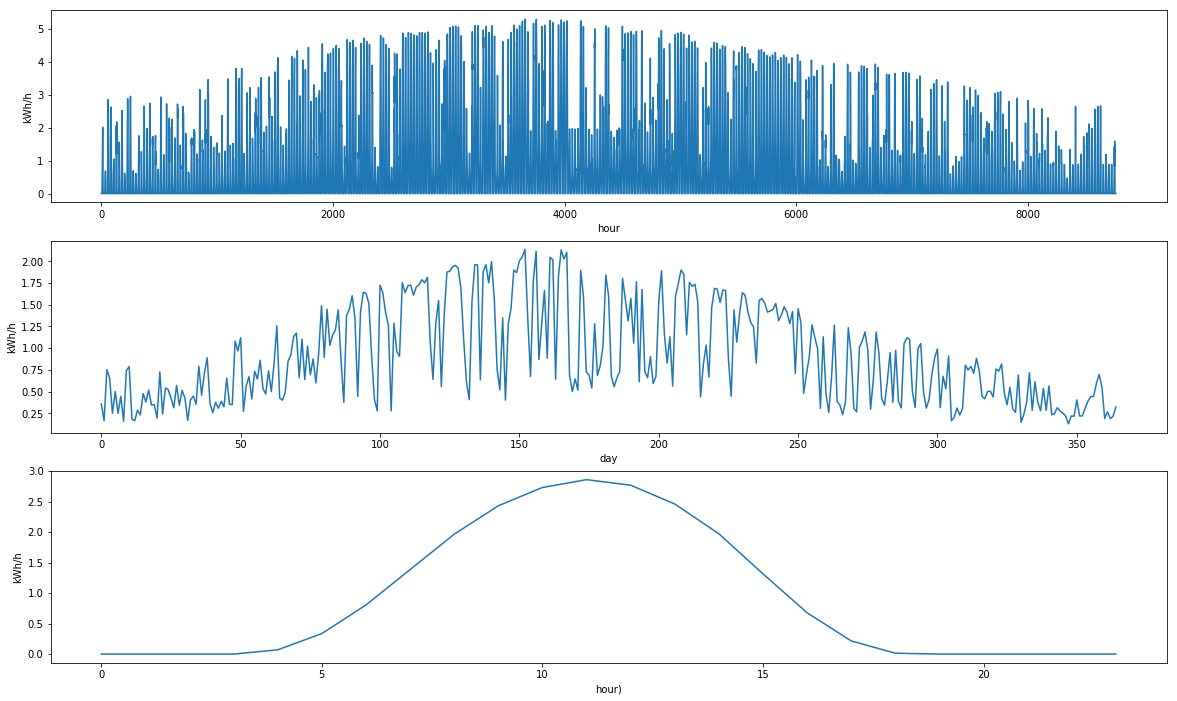

In [17]:
mkGraph(testcase1, test1_mean_day, test1_mean_hr)

### 計算条件2

In [18]:
spec = {'region' : 3, 'sol_region' : 2}
panel_list = [{'etr_IN_r' : 0.9, 'P_p_i' : 3, 'pv_type' : '結晶シリコン系', 'pv_setup' : '架台設置型', 'P_alpha' : 0, 'P_beta' : 0}]

testcase2 = calc_results(spec, panel_list)

test2_mean_hr = np.mean(testcase2.reshape(365,24), axis=0)
test2_mean_day = np.mean(testcase2.reshape(365,24), axis=1)

PV発電量:2528kWh/a(=24678MJ/a)


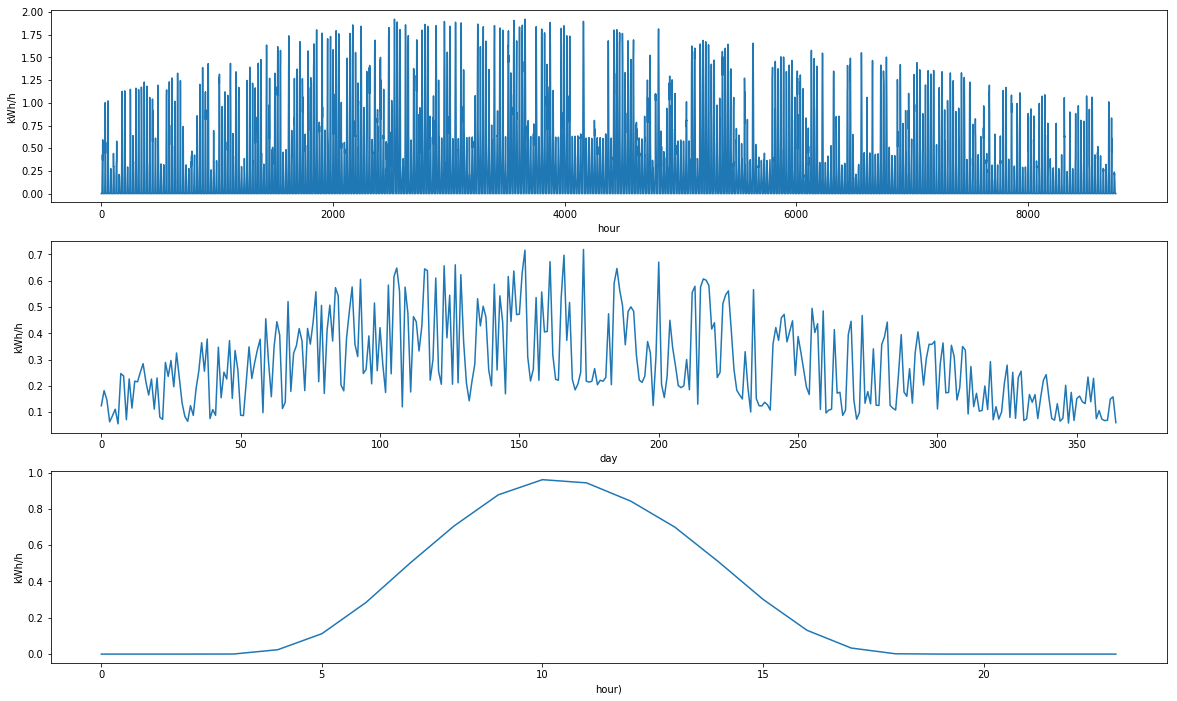

In [19]:
mkGraph(testcase2, test2_mean_day, test2_mean_hr)

### 計算条件3

In [20]:
spec = {'region' : 3, 'sol_region' : 3}
panel_list = [{'etr_IN_r' : 0.9, 'P_p_i' : 3, 'pv_type' : '結晶シリコン系', 'pv_setup' : '架台設置型', 'P_alpha' : 60, 'P_beta' : 30}]

testcase3 = calc_results(spec, panel_list)

test3_mean_hr = np.mean(testcase3.reshape(365,24), axis=0)
test3_mean_day = np.mean(testcase3.reshape(365,24), axis=1)

PV発電量:2759kWh/a(=26929MJ/a)


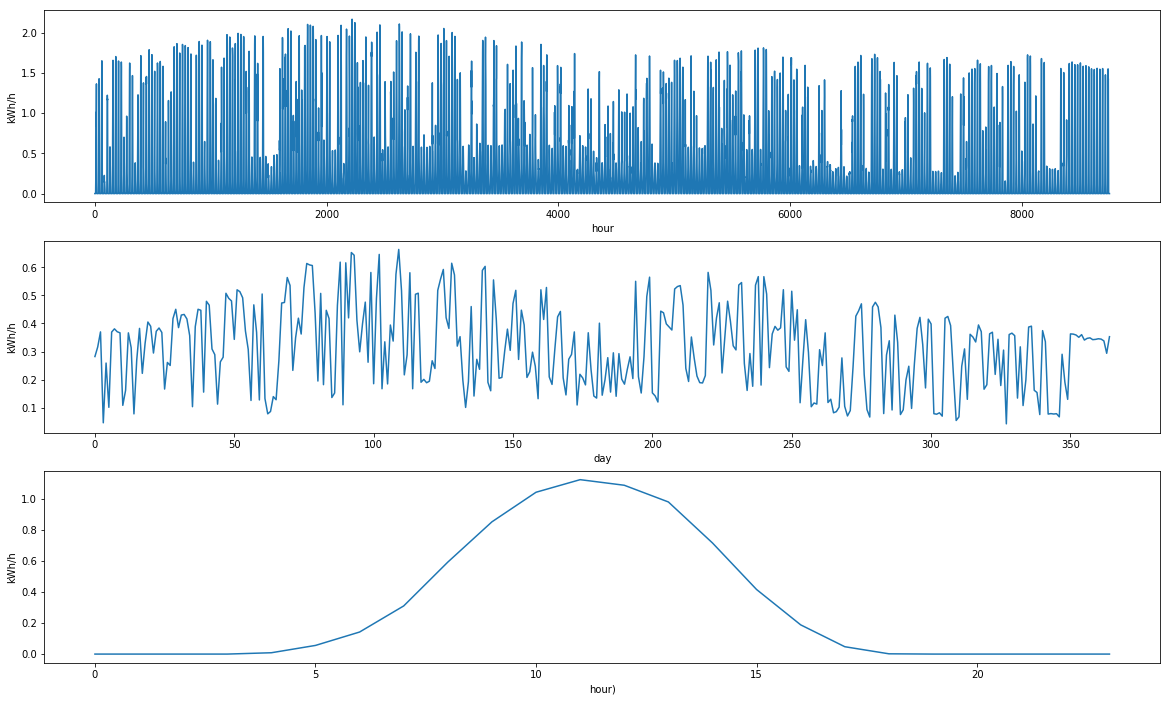

In [21]:
mkGraph(testcase3, test3_mean_day, test3_mean_hr)

### 計算条件4

In [22]:
spec = {'region' : 6, 'sol_region' : 3}
panel_list = [{'etr_IN_r' : 0.98, 'P_p_i' : 3, 'pv_type' : '結晶シリコン系', 'pv_setup' : '架台設置型', 'P_alpha' : 0, 'P_beta' : 0}]

testcase4 = calc_results(spec, panel_list)

test4_mean_hr = np.mean(testcase4.reshape(365,24), axis=0)
test4_mean_day = np.mean(testcase4.reshape(365,24), axis=1)

PV発電量:3000kWh/a(=29281MJ/a)


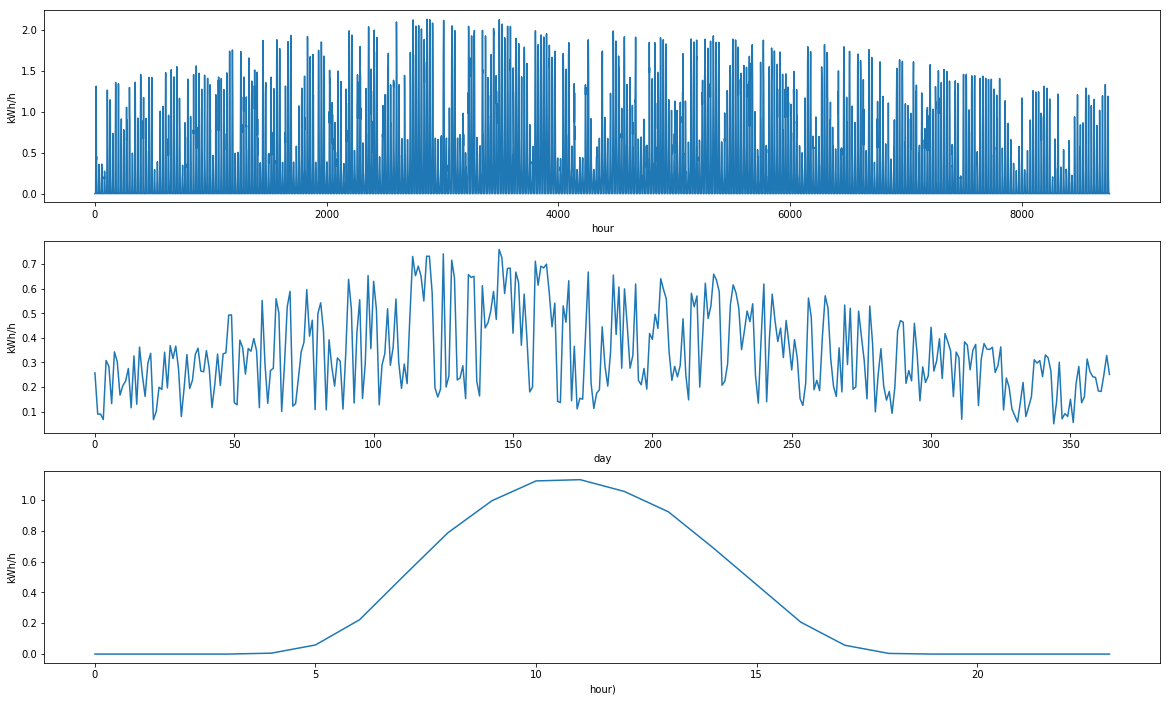

In [23]:
mkGraph(testcase4, test4_mean_day, test4_mean_hr)

### 計算条件5

In [24]:
spec = {'region' : 6, 'sol_region' : 4}
panel_list = [{'etr_IN_r' : 0.98, 'P_p_i' : 3, 'pv_type' : '結晶シリコン系', 'pv_setup' : '架台設置型', 'P_alpha' : 60, 'P_beta' : 90}]

testcase5 = calc_results(spec, panel_list)

test5_mean_hr = np.mean(testcase5.reshape(365,24), axis=0)
test5_mean_day = np.mean(testcase5.reshape(365,24), axis=1)

PV発電量:1848kWh/a(=18042MJ/a)


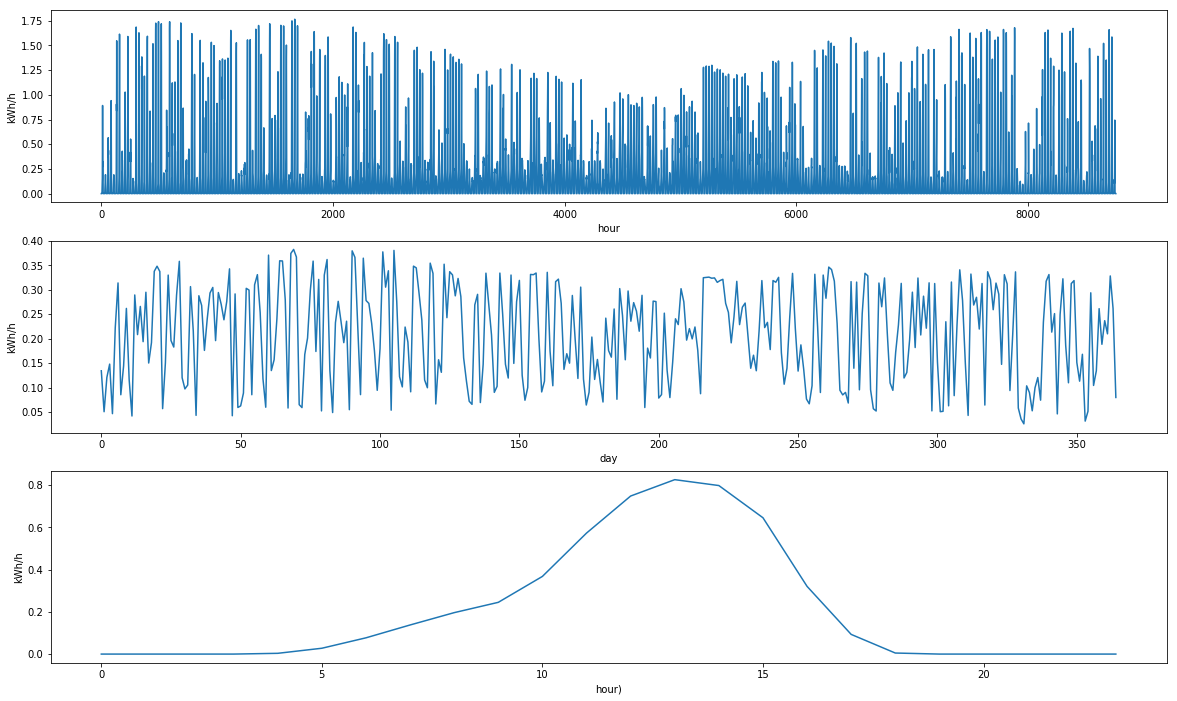

In [25]:
mkGraph(testcase5, test5_mean_day, test5_mean_hr)

### 比較

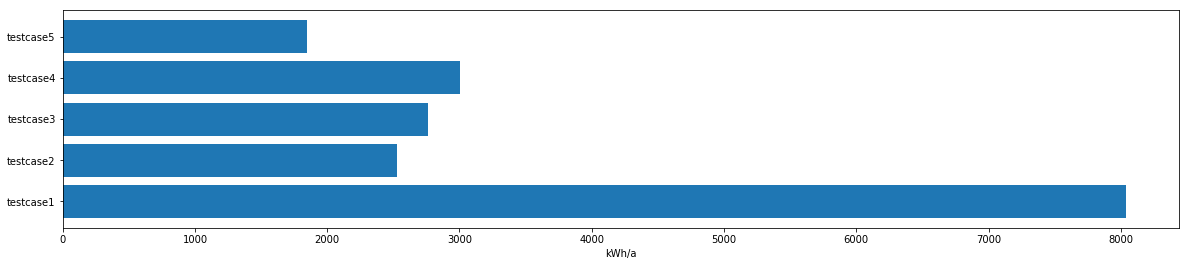

In [26]:
dat = {"testcase1":sum(testcase1),"testcase2" : sum(testcase2), "testcase3" : sum(testcase3), "testcase4" : sum(testcase4), 
       "testcase5" : sum(testcase5)}
xx = list(dat.keys())
yy = list(dat.values())

fig = plt.figure(figsize=(20,4))
axt = fig.add_subplot(111)
axt.barh(xx,yy)
axt.set_xlabel("kWh/a")
plt.show()


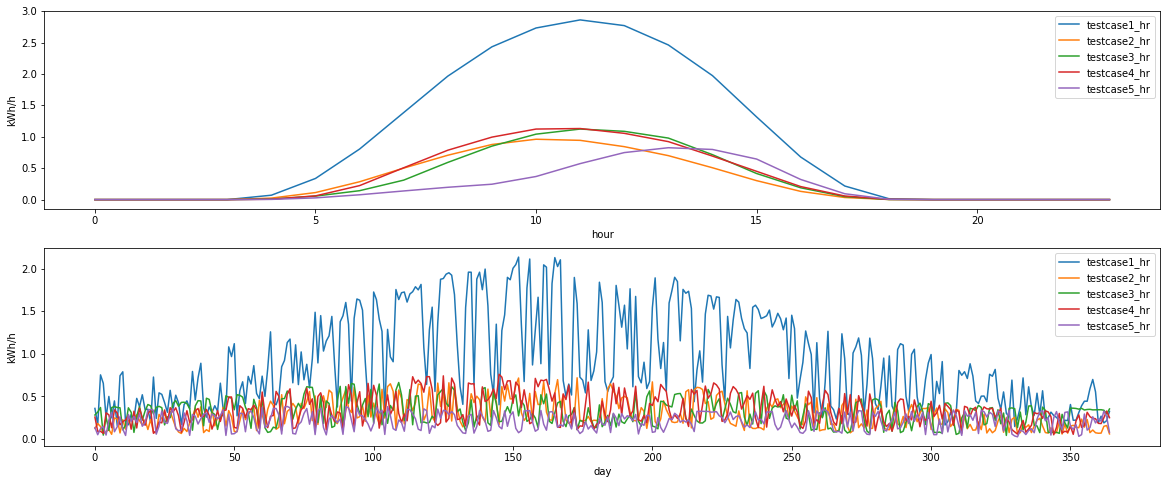

In [27]:
dat_hr = {"testcase1_hr" : test1_mean_hr, "testcase2_hr" : test2_mean_hr, "testcase3_hr" : test3_mean_hr, 
          "testcase4_hr" : test4_mean_hr, "testcase5_hr" : test5_mean_hr}
xx_hr = list(dat_hr.keys())

dat_day = {"testcase1_day" : test1_mean_day, "testcase2_day" : test2_mean_day, "testcase3_day" : test3_mean_day,
          "testcase4_day" : test4_mean_day, "testcase5_day" : test5_mean_day}
xx_day = list(dat_day.keys())

fig = plt.figure(figsize=(20,8))
ax_hr = fig.add_subplot(211)
ax_day = fig.add_subplot(212)

for k in dat_hr.keys():
    ax_hr.plot(dat_hr[k])
    
ax_hr.legend(xx_hr)
ax_hr.set_ylabel("kWh/h")
ax_hr.set_xlabel("hour")

for k in dat_day.keys():
    ax_day.plot(dat_day[k])

ax_day.legend(xx_hr)
ax_day.set_ylabel("kWh/h")
ax_day.set_xlabel("day")
plt.show()
